##### Project 1,
Data 620,
##### Team 1: Jason Givens-Doyle, Mehdi Khan, Paul Britton

Introduction: 
We decided to use movie data that can be downloaded from https://www.themoviedb.org using their API.  The dataset contains
detail information about movies such as top-rated movies, ratings, movies marked as favorite by the users, categories etc.  

Our analysis will include selecting a certain genre of movies or a series of popular movies (such all super hero movies) . The nodes of the graph will represent the actors and movies and the highest centrality for actor nodes will be determined by the actor who has the most connections to  different movies. That is, the higher the centrality, the higher the influence of the actor.

We wanted to determine who are the most influential actors in the movie collection. By adding gender attributes to actor nodes we will also try to find if most of the influential actors are male or female.


First all the required packages were imported:

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tmdbsimple as mdb
import json
import requests 
import matplotlib.colors as mcolors

We decided to use X-MEN movie series in our project. In the movie database website each movie and the collection of movies
are stored with their unique ID, which can be used to get information about a collection and individual movies in 
that collection. In order to access to the database an API key was also required. The ID for X-MEN collection is '748' which was used to get the movie list. The movie list was collected in json format:

In [2]:
result = requests.get("https://api.themoviedb.org/3/collection/748?api_key=e0e12838e7f1ca7a7a239963f5dd9901").json()
res = []
rs = result['parts']

A dataframe was created with the information to create a nodelist for the movie names. The movie titles were used later 
to collect actor information later:

In [3]:
for item in rs:    
    m_dict = {}
    
    m_dict['id']=item.get('id')
    m_dict['title']=item.get('title')
    m_dict['popularity']=item.get('popularity')
    m_dict['vote_average']=item.get('vote_average')
    m_dict['node_movie'] = (item.get('title'),{'type':'movie','gender':'na'})
    res.append(m_dict)

movieDB = pd.DataFrame(res)
movieDB= movieDB.drop(movieDB[movieDB.title=='The New Mutants'].index)

A function was created that takes the movie id and title and return actor information, gender and other information as a list. 
The list was then used to create actor nodes and edges for the graph:

In [4]:
def get_cast(movie_id,title):
        result = requests.get("https://api.themoviedb.org/3/movie/"+str(movie_id)+"?api_key=e0e12838e7f1ca7a7a239963f5dd9901&append_to_response=credits").json()
        credits = result["credits"]
        cast = []        
        castlist = credits.get('cast')
        for item in castlist:
            castdict = {}
            attdict ={}
            castdict['name'] = item.get('name')
            castdict['gender'] = 'M' if item.get('gender')==2 else 'F' if item.get('gender')==1 else 'N'
            castdict['edge_cast'] = (item.get('name'),title)
            attdict['type']='actor'
            attdict['gender']=castdict.get('gender')
            castdict['node_cast'] = (item.get('name'),attdict)
            cast.append(castdict)
        return cast
            
mvlist = []
for index, row in movieDB.iterrows():
    mvlist = mvlist + get_cast(row['id'],row['title'])
    
castDB = pd.DataFrame(mvlist)

nodecast = castDB[['name','node_cast']]
nodecast = nodecast.drop_duplicates('name')

Creation of the network graph:
seperate nodelist were created for movie names, actors and actresses. Movie names, actors and actresses were rendered 
in red, blue and green respectively. Certain cast members did not have their genders specified, which were renderd in brown. 
The size of each movie names were made bigger and they were also labeled:

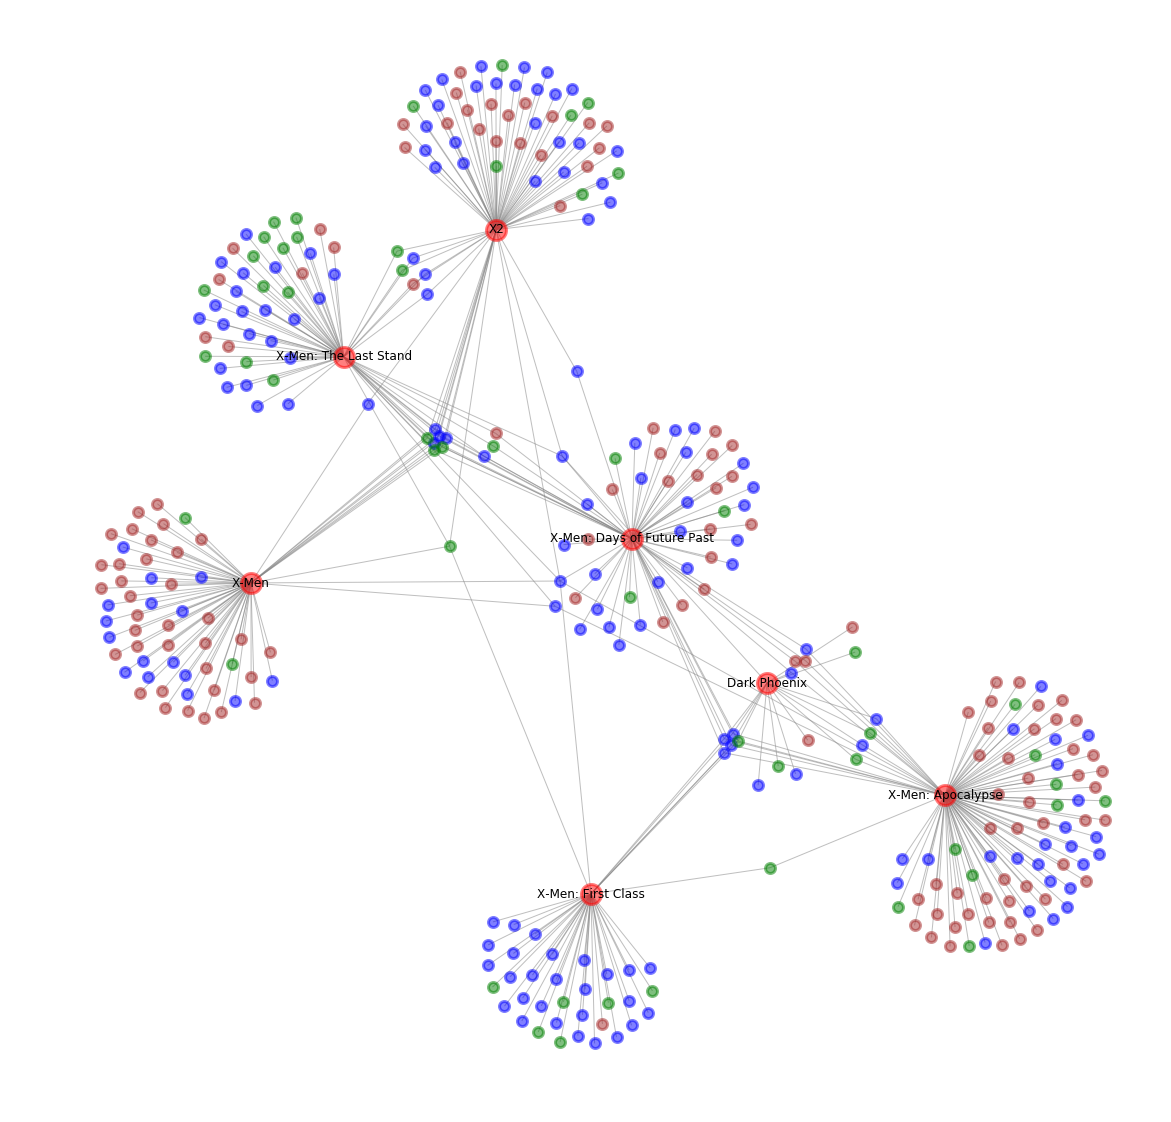

In [5]:
G = nx.Graph()
G.add_edges_from(castDB['edge_cast'].tolist())
G.add_nodes_from(movieDB['node_movie'].tolist()+nodecast['node_cast'].tolist())

pos = nx.spring_layout(G)

plt.figure(figsize=(20,20))

movie_nodes = [n for (n,type) in nx.get_node_attributes(G,'type').items() if type=='movie']
actor_nodes = [n for (n,gender) in nx.get_node_attributes(G,'gender').items() if gender=='M']
actress_nodes = [n for (n,gender) in nx.get_node_attributes(G,'gender').items() if gender=='F']
nogender_nodes = [n for (n,gender) in nx.get_node_attributes(G,'gender').items() if gender=='N']

labels ={}
for node in movie_nodes:
    labels[node]=node


nx.draw_networkx_edges(G, pos, edge_color="Gray", alpha=0.5)
nx.draw_networkx_nodes(G,pos,nodelist= movie_nodes,node_size=400, alpha=.5,node_color="r", node_shape="o", linewidths=3, with_label=True)
nx.draw_networkx_nodes(G,pos,nodelist= actor_nodes,node_size=100, alpha=.5,node_color="b", node_shape="o", linewidths=3)
nx.draw_networkx_nodes(G,pos,nodelist= actress_nodes,node_size=100, alpha=.5,node_color="g", node_shape="o", linewidths=3)
nx.draw_networkx_nodes(G,pos,nodelist= nogender_nodes,node_size=100, alpha=.5,node_color="brown", node_shape="o", linewidths=3)
nx.draw_networkx_labels(G,pos,labels)
plt.axis('off')
plt.show()

Each claster in the above graph shows the concentrations of individual actors around  movies, who were only present in 
those movies only, while some actors acted in different movies and show in the graph connecting different clusters  

The follwing function was used to find the 20 most influential actors by using their degree centrality, eigenvector centrality: 

In [6]:
def get_centrality(measure,centrality):
    
    dcenDF = pd.DataFrame(sorted(measure.items(),key=lambda x: -x[1]))
    dcenDF.columns=["cast",centrality]
    gender=[]
    for idx, row in dcenDF.iterrows():    
        gender.append(G.node[row['cast']]['gender'])
    dcenDF['gender']=gender
    dcenDF = dcenDF.drop(dcenDF[dcenDF.gender=='na'].index)
    return  dcenDF.head(20)

##### Degree Centrality:

In [7]:
get_centrality(nx.degree_centrality(G),'deg_cen') 

,cast,deg_cen,gender
7,Hugh Jackman,0.017143,M
8,Patrick Stewart,0.011429,M
9,Ian McKellen,0.011429,M
10,Famke Janssen,0.011429,F
11,James Marsden,0.011429,M
12,Halle Berry,0.011429,F
13,Anna Paquin,0.011429,F
14,Rebecca Romijn,0.011429,F
15,Shawn Ashmore,0.011429,M
16,Daniel Cudmore,0.011429,M


As the above table shows, Hugh Jackman is the most influential actor in the X-MEN movie series. Among 20 most influential cast
members 14 are males and only 6 are females.

So at least for X-MEN movies, we can say the male actors are more influential.

#### Eigenvector Centrality:

In [8]:
get_centrality(nx.eigenvector_centrality(G),'eigen_cen') 

,cast,eigen_cen,gender
5,Hugh Jackman,0.153488,M
7,Patrick Stewart,0.097896,M
8,Ian McKellen,0.097896,M
9,Famke Janssen,0.097896,F
10,James Marsden,0.097896,M
11,Halle Berry,0.097896,F
12,Anna Paquin,0.097896,F
13,Shawn Ashmore,0.097896,M
14,James McAvoy,0.092752,M
15,Michael Fassbender,0.092752,M


The general conclusion from the degree centrality remain true for eigenvector centrality too. Only difference is that 
'Zehra Leverman' was added in the list, who is an actress although her gender was not specified in the database and
shows in the table as 'N' for gender


#### The shortest paths:

In [9]:
get_centrality(nx.betweenness_centrality(G),'betweem_cen') 

,cast,betweem_cen,gender
5,Hugh Jackman,0.242676,M
7,Stan Lee,0.077020,M
8,Rebecca Romijn,0.059940,F
10,Daniel Cudmore,0.029086,M
11,Patrick Stewart,0.026201,M
12,Ian McKellen,0.026201,M
13,Famke Janssen,0.026201,F
14,James Marsden,0.026201,M
15,Halle Berry,0.026201,F
16,Anna Paquin,0.026201,F


betweenness centrality is a measure of centrality in a graph based on shortest paths. Again more male cast memebers show 
higher betweenness centrality and therefore they have more control over the network.

Centrality visualization:
Following function was used to visualize centrality:

In [10]:
def draw_cen(measures, measure_name):
    plt.figure(figsize=(20,20))
    color_values = []
    for x in measures.values():         
        color_values.append(float(x))
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.plasma, 
                                   node_color=color_values,
                                   nodelist=nx.degree_centrality(G).keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))    
    
    edges = nx.draw_networkx_edges(G, pos)
   
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

##### Visualization of degree centrality:

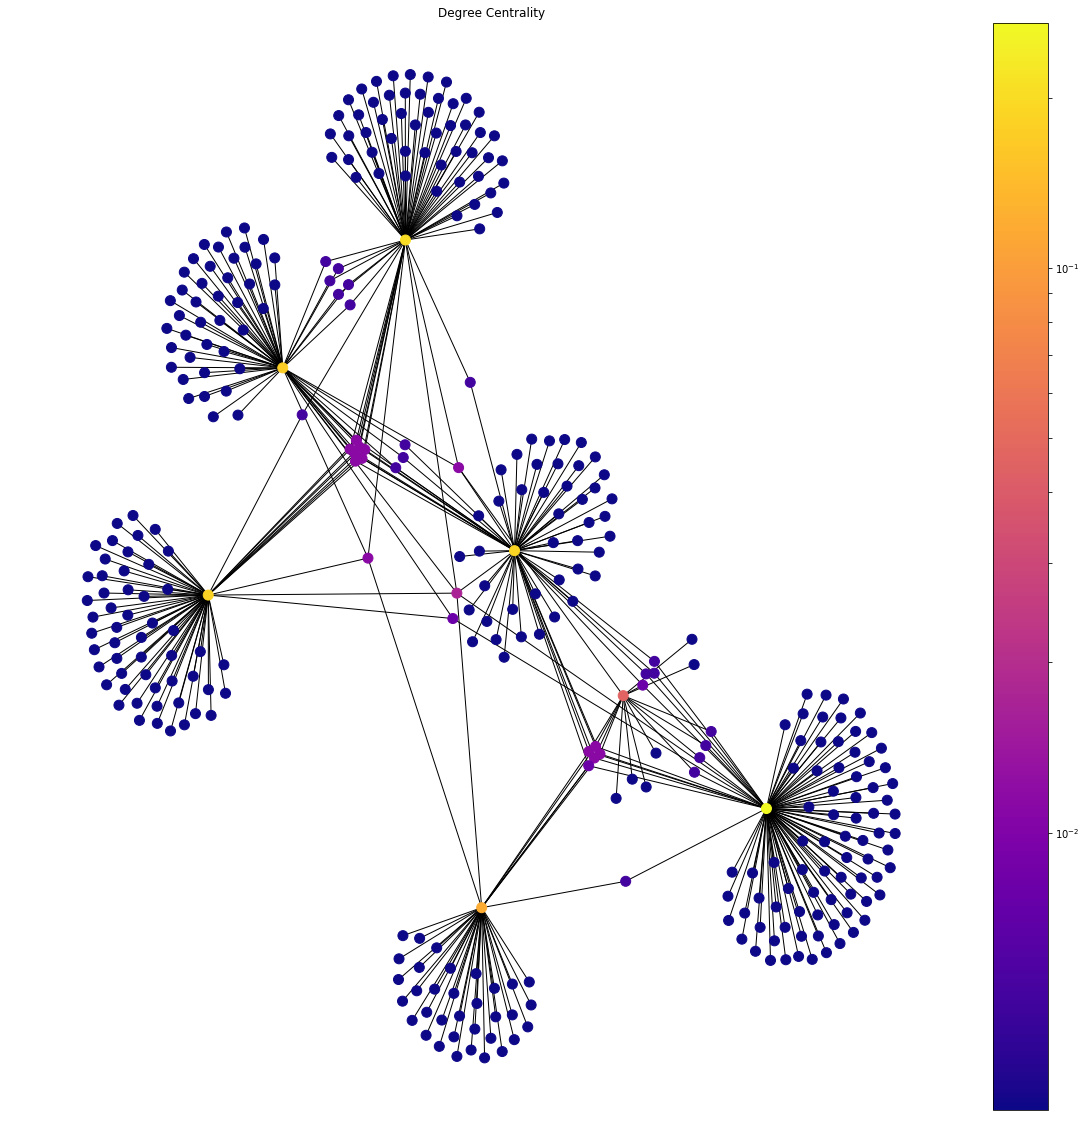

In [11]:
draw_cen(nx.degree_centrality(G), 'Degree Centrality')

##### Visualization of eigenvector centrality:

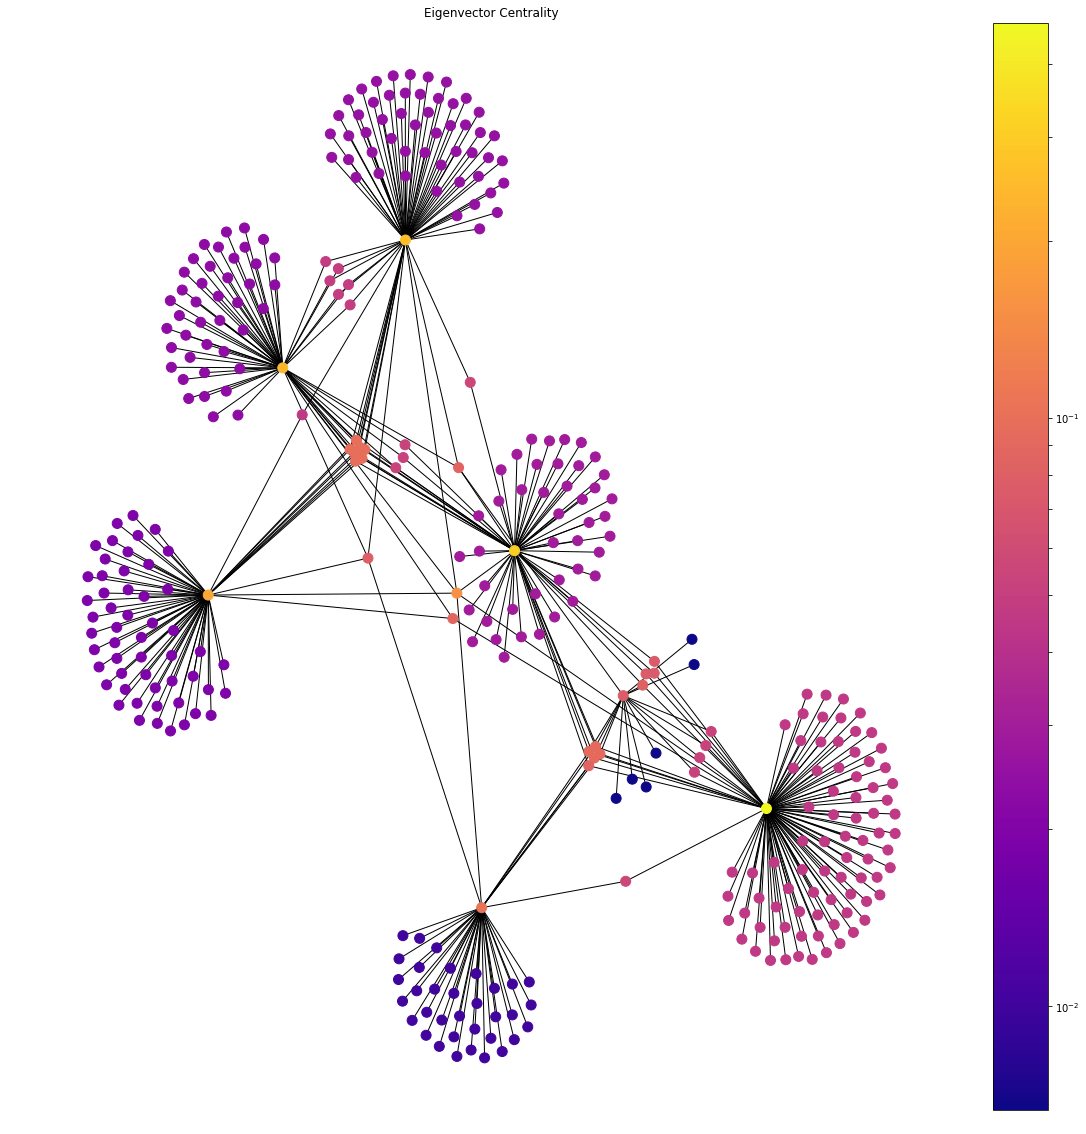

In [12]:
draw_cen(nx.eigenvector_centrality(G), 'Eigenvector Centrality')

References:

Some codes were borrowed for draw_cen(measures, measure_name) function from the follwing website:
https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
    